In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
import splitfolders
import os

In [6]:
IMAGE_SIZE = 224
CHANNELS = 3

In [4]:
dataset_path = "../Dataset"

In [7]:
for category_folder in os.listdir(dataset_path):
    print(category_folder)

Tomato_Bacterial_spot
Tomato_Early_blight
Tomato_healthy
Tomato_Late_blight
Tomato_Leaf_Mold
Tomato_Septoria_leaf_spot
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Target_Spot
Tomato__Tomato_mosaic_virus
Tomato__Tomato_YellowLeaf__Curl_Virus


In [8]:
splitfolders.ratio(dataset_path, output="../output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 16010 files [01:48, 148.23 files/s]


In [13]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("directory created!")
        
        

In [14]:
create_dir("./AugmentedImages")

directory created!


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        '../output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
        save_to_dir="./AugmentedImages"
)

Found 12804 images belonging to 10 classes.


In [5]:
train_generator.class_indices

{'Tomato_Bacterial_spot': 0,
 'Tomato_Early_blight': 1,
 'Tomato_Late_blight': 2,
 'Tomato_Leaf_Mold': 3,
 'Tomato_Septoria_leaf_spot': 4,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 5,
 'Tomato__Target_Spot': 6,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7,
 'Tomato__Tomato_mosaic_virus': 8,
 'Tomato_healthy': 9}

In [16]:
train_generator[0][0].shape

(32, 224, 224, 3)

In [18]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        '../output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 1597 images belonging to 10 classes.


In [26]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        '../output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
        shuffle=True
)

Found 1609 images belonging to 10 classes.


In [20]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
print(input_shape)

(224, 224, 3)


In [21]:
# Define the model building function

def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))  # can pass input_shape directly
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add dropout and L2 regularization to the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32, default=128)
    x = Dense(dense_units, activation='relu', kernel_regularizer=keras.regularizers.l2(hp.Float('l2_regularization', min_value=1e-6, max_value=1e-3, sampling='log')))(x)
    x = layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.2))(x)
    
    output = Dense(n_classes, activation='softmax')(x)

    model = keras.Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',  # Fixed the mistake here
        metrics=['accuracy']
    )

    return model



In [ ]:
# assign different class weight

In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [23]:
class_labels = np.unique(train_generator.classes)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = class_labels,
                                        y = train_generator.classes                                                 
                                    )
class_weight_dict = dict(zip(class_labels, class_weights))

# Print computed class weights
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 0.7527336860670194, 1: 1.6005, 2: 0.8385068762278979, 3: 1.6825229960578187, 4: 0.9042372881355932, 5: 0.9555223880597015, 6: 1.140160284951024, 7: 0.4989867498051442, 8: 4.296644295302014, 9: 1.0066037735849056}


In [27]:
# Initialize tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    directory='tuner_logs',
    project_name='efficientnet_tuning'
)

In [29]:
# Perform hyperparameter search

tuner.search(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight = class_weight_dict
)

Trial 2 Complete [02h 06m 38s]
val_accuracy: 0.9974952936172485

Best val_accuracy So Far: 0.9974952936172485
Total elapsed time: 04h 17m 26s


In [34]:
# Get the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(1)[0]

# get the best model
best_model = tuner.get_best_models(1)[0]

In [35]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │     864 │ input_layer[0][0]    │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_bn             │ (None, 112, 112,  │     128 │ stem_conv[0][0]      │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_activation     │ (None, 112, 112,  │       0 │ stem_bn[0][0]        │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │     288 │ stem_activation[0][… │
│ (DepthwiseConv2D)   │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_bn          │ (None, 112, 112,  │     128 │ block1a_dwconv[0][0] │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_activation  │ (None, 112, 112,  │       0 │ block1a_bn[0][0]     │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │       0 │ block1a_activation[… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │       0 │ block1a_se_squeeze[… │
│ (Reshape)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │     264 │ block1a_se_reshape[… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │     288 │ block1a_se_reduce[0… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │       0 │ block1a_activation[… │
│ (Multiply)          │ 32)               │         │ block1a_se_expand[0… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │     512 │ block1a_se_excite[0… │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │      64 │ block1a_project_con… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_conv │ (None, 112, 112,  │   1,536 │ block1a_project_bn[… │
│ (Conv2D)            │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_bn   │ (None, 112, 112,  │     384 │ block2a_expand_conv… │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_act… │ (None, 112, 112,  │       0 │ block2a_expand_bn[0

 Total params: 4,504,006 (17.18 MB)

 Trainable params: 4,461,990 (17.02 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [36]:
model =tuner.hypermodel.build(best_hps)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │     864 │ input_layer_1[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_bn             │ (None, 112, 112,  │     128 │ stem_conv[0][0]      │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_activation     │ (None, 112, 112,  │       0 │ stem_bn[0][0]        │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │     288 │ stem_activation[0][… │
│ (DepthwiseConv2D)   │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_bn          │ (None, 112, 112,  │     128 │ block1a_dwconv[0][0] │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_activation  │ (None, 112, 112,  │       0 │ block1a_bn[0][0]     │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │       0 │ block1a_activation[… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │       0 │ block1a_se_squeeze[… │
│ (Reshape)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │     264 │ block1a_se_reshape[… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │     288 │ block1a_se_reduce[0… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │       0 │ block1a_activation[… │
│ (Multiply)          │ 32)               │         │ block1a_se_expand[0… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │     512 │ block1a_se_excite[0… │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │      64 │ block1a_project_con… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_conv │ (None, 112, 112,  │   1,536 │ block1a_project_bn[… │
│ (Conv2D)            │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_bn   │ (None, 112, 112,  │     384 │ block2a_expand_conv… │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_act… │ (None, 112, 112,  │       0 │ block2a_expand_bn[0

 Total params: 4,504,006 (17.18 MB)

 Trainable params: 4,461,990 (17.02 MB)

 Non-trainable params: 42,016 (164.12 KB)

None


In [37]:
model.compile(
    optimizer=tf.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=31,
    verbose=1,
    epochs=5,
    class_weight = class_weight_dict
)

Epoch 1/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 1654s 4s/step - accuracy: 0.9464 - loss: 0.1852 - val_accuracy: 0.9778 - val_loss: 0.0601
Epoch 2/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 1525s 4s/step - accuracy: 0.9660 - loss: 0.1193 - val_accuracy: 0.9421 - val_loss: 0.1686
Epoch 3/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 1467s 4s/step - accuracy: 0.9738 - loss: 0.0695 - val_accuracy: 0.9758 - val_loss: 0.0745
Epoch 4/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 1617s 4s/step - accuracy: 0.9841 - loss: 0.0479 - val_accuracy: 0.9934 - val_loss: 0.0399
Epoch 5/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 1733s 4s/step - accuracy: 0.9824 - loss: 0.0491 - val_accuracy: 0.9778 - val_loss: 0.0895


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
predictions = best_model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes

51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [42]:
print("Classification Report:\n", classification_report(true_classes, predicted_classes))
print("\nConfusion Matrix:\n", confusion_matrix(true_classes, predicted_classes))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       214
           1       0.97      0.99      0.98       100
           2       0.99      0.98      0.99       192
           3       1.00      1.00      1.00        96
           4       1.00      0.99      1.00       178
           5       0.99      1.00      1.00       169
           6       1.00      0.99      1.00       141
           7       0.99      1.00      1.00       322
           8       1.00      1.00      1.00        38
           9       0.99      1.00      1.00       159

    accuracy                           0.99      1609
   macro avg       0.99      0.99      0.99      1609
weighted avg       0.99      0.99      0.99      1609


Confusion Matrix:
 [[211   0   0   0   0   0   0   3   0   0]
 [  0  99   1   0   0   0   0   0   0   0]
 [  0   2 189   0   0   0   0   0   0   1]
 [  0   0   0  96   0   0   0   0   0   0]
 [  0   1   0   0 177   0

In [ ]:
# for loss and accuracy value

In [43]:
scores = model.evaluate(test_generator)

51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 692ms/step - accuracy: 0.9690 - loss: 0.1134


In [44]:
scores

[0.08854927867650986, 0.9738968014717102]

In [ ]:
# Plotting the Accuracy and Loss Curves

In [45]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

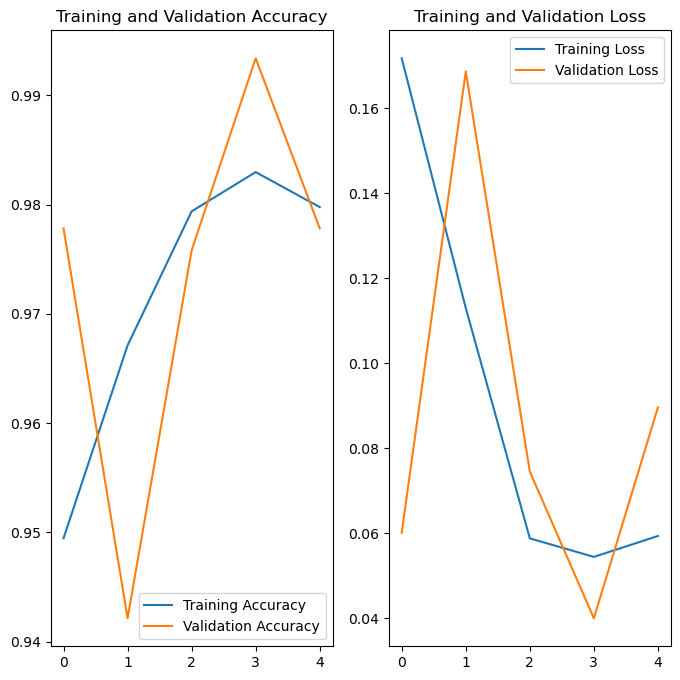

In [48]:
import matplotlib.pyplot as plt
EPOCHS = 5

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [20]:
class_names = list(train_generator.class_indices.keys())
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
""" Importing model directly """

In [16]:
MODEL_PATH = "./efficient.h5"
model = tf.keras.models.load_model(MODEL_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


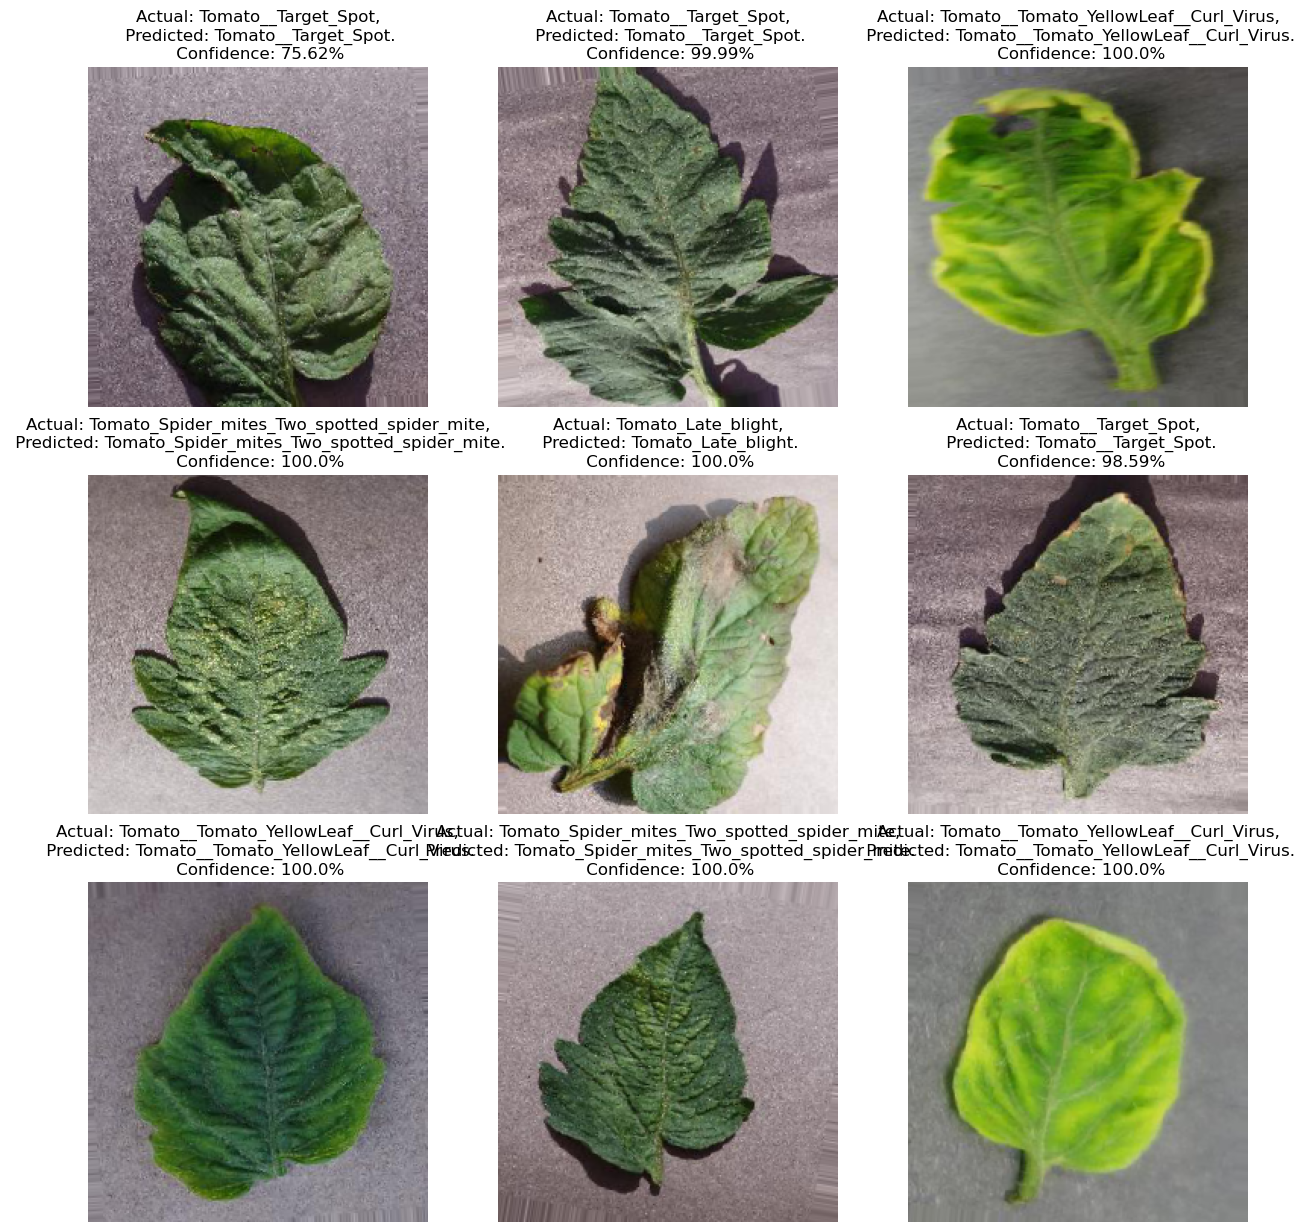

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [ ]:
# saving model

In [55]:
model.save("./efficient.h5")

In [3]:
# Load the Keras model
MODEL = tf.keras.models.load_model("./efficient.h5")

# Convert the Keras model to the TensorFlow SavedModel format
tf.saved_model.save(MODEL, "efficientnet_saved_model")

INFO:tensorflow:Assets written to: efficientnet_saved_model\assets


INFO:tensorflow:Assets written to: efficientnet_saved_model\assets
